In [260]:
import pypsa
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Настройка периода симуляции ---
start_date = '2020-01-01 00:00:00'
end_date = '2020-01-01 23:00:00'

# --- 2. Загрузка данных ---
df_plants = pd.read_csv('custom_powerplants_updated.csv')
df_buses = pd.read_excel('buses.xlsx')
df_loads = pd.read_excel('Load_2018-2020 (datetime).xlsx')
df_lines = pd.read_excel('lines_with_length.xlsx')
weather_xls = pd.ExcelFile("Total - данные по солнцу и ветру (конвертировано).xlsx")

# --- 3. Обработка погодных данных ---
solar_radiation_by_node = {}
wind_speed_by_node = {}

for sheet in weather_xls.sheet_names:
    df = weather_xls.parse(sheet)
    df["time"] = pd.to_datetime(df["time"])

    if sheet not in df_buses["Name"].values:
        continue

    df["G_total"] = df["Gb(i)"] + df["Gd(i)"] + df["Gr(i)"]
    df["wind_speed"] = df["WS10m"]

    solar_radiation_by_node[sheet] = df.set_index("time")["G_total"]
    wind_speed_by_node[sheet] = df.set_index("time")["wind_speed"]

solar_radiation_df = pd.DataFrame(solar_radiation_by_node)
wind_speed_df = pd.DataFrame(wind_speed_by_node)

# --- 4. Подготовка нагрузки ---
df_loads["datetime"] = pd.to_datetime(df_loads["datetime"])
df_loads = df_loads.set_index("datetime").loc[start_date:end_date]

# --- 5. Настройка сети ---
network = pypsa.Network()
network.set_snapshots(df_loads.index)

# Приведение погодных данных к snapshots
solar_radiation_df = solar_radiation_df.reindex(network.snapshots)
wind_speed_df = wind_speed_df.reindex(network.snapshots)

# --- 6. Добавление узлов ---
for _, row in df_buses.iterrows():
    network.add("Bus", name=row['Name'], v_nom=220.0, x=row['lon'], y=row['lat'], carrier="AC")

# --- 7. Добавление генераторов с профилями солнечных и ветровых генераций ---
for i, row in df_plants.iterrows():
    name = f"gen_{i}"
    bus = row['bus']
    carrier = row['Fueltype'].lower()
    p_nom = row['Capacity']

    if carrier == "solar" and bus not in solar_radiation_df.columns:
        continue
    if carrier == "wind" and bus not in wind_speed_df.columns:
        continue

    network.add("Generator",
                name=name,
                bus=bus,
                carrier=carrier,
                p_nom=p_nom,
                marginal_cost=50,
                p_nom_extendable=False)

    if carrier == "solar":
        norm_profile = solar_radiation_df[bus] / solar_radiation_df[bus].max()
        network.generators_t.p_max_pu.loc[:, name] = norm_profile.values

    elif carrier == "wind":
        norm_profile = wind_speed_df[bus] / wind_speed_df[bus].max()
        network.generators_t.p_max_pu.loc[:, name] = norm_profile.values

# --- 8. Добавление нагрузок ---
load_scaling_factor = 2.25 #1.05 * 1.5

for _, row in df_buses.iterrows():
    network.add("Load", name=f"Load_{row['Name']}", bus=row['Name'], p_set=0)

for _, row in df_buses.iterrows():
    load_name = f"Load_{row['Name']}"
    if row['Name'] in df_loads.columns:
        network.loads_t.p_set.loc[:, load_name] = df_loads[row['Name']] * load_scaling_factor

# --- 9. Добавление линий ---
r_per_km = 0.03
x_per_km = 0.4

for _, row in df_lines.iterrows():
    network.add("Line",
                name=f"Line from {row['Bus1']} to {row['Bus2']}",
                bus0=row['Bus1'],
                bus1=row['Bus2'],
                r=r_per_km * row['length_km'],
                x=x_per_km * row['length_km'],
                s_nom=300,
                v_nom=220)

# --- 10. Добавление недостающих carrier'ов ---
all_carriers = pd.concat([
    network.generators['carrier'],
    network.lines['carrier'],
    network.buses['carrier']
], axis=0).dropna().unique()

for carrier in all_carriers:
    if carrier not in network.carriers.index:
        network.add("Carrier", name=carrier)

In [261]:
N = 6.66 # во сколько раз увеличить мощность угольных станций с 4.5 (2020) в 1,48 раза (2030 год)
A = 4.386 # во сколько увеличить мощность газовых станций с 1.7 (2020) в 2.58 раза (2030 год)

# Фильтруем существующие генераторы, исключая солнечные и ветровые, газовые
non_vres_mask_coal = ~network.generators.carrier.isin(['solar', 'wind', 'hydro', 'ocgt', 'ccgt'])
# Фильтруем существующие генераторы, исключая солнечные и ветровые, угольные
non_vres_mask_gas = ~network.generators.carrier.isin(['solar', 'wind', 'hydro', 'coal'])

# Умножаем номинальную мощность
network.generators.loc[non_vres_mask_coal, 'p_nom'] *= N
network.generators.loc[non_vres_mask_gas, 'p_nom'] *= A


In [197]:

# --- 11. Оптимизация ---
network.optimize()

# --- 12. Визуализация генерации по типу ---
gen_p = network.generators_t.p.groupby(network.generators.carrier, axis=1).sum()
gen_p.plot(title="Генерация по типу источника", figsize=(10, 4))
plt.ylabel("МВт")
plt.grid(True)
plt.tight_layout()
plt.show()


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.02s
Status: warning
Termination condition: infeasible
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: infeasible



Running HiGHS 1.9.0 (git hash: fa40bdf): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 6e+02]
  Cost   [5e+01, 5e+01]
  Bound  [0e+00, 0e+00]
  RHS    [2e-02, 3e+04]
Presolving model
Problem status detected on presolve: Infeasible
Model name          : linopy-problem-koaoozht
Model status        : Infeasible
Objective value     :  0.0000000000e+00
HiGHS run time      :          0.00
Writing the solution to /private/var/folders/1s/c9vjd4d56sx8xysxk042mq1r0000gn/T/linopy-solve-aixllxru.sol


/var/folders/1s/c9vjd4d56sx8xysxk042mq1r0000gn/T/ipykernel_1368/2374090591.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  gen_p = network.generators_t.p.groupby(network.generators.carrier, axis=1).sum()


TypeError: no numeric data to plot

In [ ]:
# Группируем генераторов по типу и складываем генерацию по каждому часу
generation_by_carrier = network.generators_t.p.groupby(network.generators.carrier, axis=1).sum()

# Оставим только 'solar' и 'wind'
generation_by_carrier = generation_by_carrier[["solar", "wind"]]

# Цвета: solar — жёлтый, wind — синий
colors = {"solar": "gold", "wind": "royalblue"}

# Строим график
generation_by_carrier.plot(figsize=(12, 5), linewidth=2, color=[colors[col] for col in generation_by_carrier.columns])
plt.title("Generation from solar and wind sources (MW)")
plt.ylabel("Power (MW)")
plt.xlabel("Time")
plt.grid(True)
plt.tight_layout()
plt.show()


carrier
hard coal    68.437661
ccgt         17.172687
ocgt          8.930377
wind          2.661537
hydro         1.683247
solar         1.114491
dtype: float64


/var/folders/1s/c9vjd4d56sx8xysxk042mq1r0000gn/T/ipykernel_1368/1327098482.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  carrier_generation = generation.groupby(network.generators.carrier, axis=1).sum()


<Axes: title={'center': 'Percentage of generation by type in one day in 2020'}>

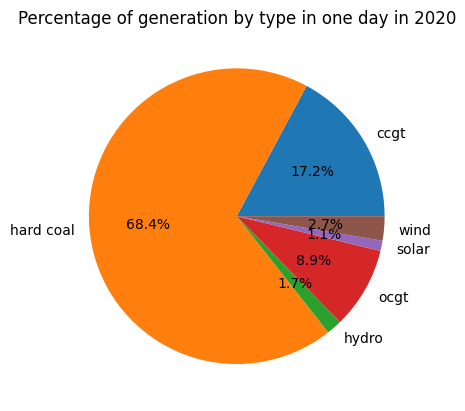

In [156]:
generation = network.generators_t.p  # [MW]

carrier_generation = generation.groupby(network.generators.carrier, axis=1).sum()
total_generation = carrier_generation.sum().sum()  # общая энергия за весь период

carrier_share = carrier_generation.sum() / total_generation * 100
print(carrier_share.sort_values(ascending=False))

carrier_share.plot(kind='pie', autopct='%1.1f%%', ylabel='', title='Percentage of generation by type in one day in 2020')

In [262]:
z = 1

solar_generators = [
    ("solar_SEM", "SEM", 30),
    ("solar_KAR", "KAR", 190),
    ("solar_ZhEZ", "ZhEZ", 2772),
    ("solar_KOST", "KOST", 98),
    ("solar_AKM1", "AKM1", 100),
    ("solar_AKT", "AKT", 2452),
    ("solar_ALM", "ALM", 2452),
    ("solar_TALD", "TALD", 78),
    ("solar_ZHAM", "ZHAM", 2668),
    ("solar_TURK", "TURK", 2772)
]

for name, bus, p_nom in solar_generators:
    if bus not in solar_radiation_df.columns:
        print(f"⚠️ Нет солнечного профиля для узла {bus}, пропущено {name}")
        continue

    ghi_normalized = solar_radiation_df[bus] / solar_radiation_df[bus].max()
    ghi_normalized = ghi_normalized.reindex(network.snapshots)  # на всякий случай

    network.add("Generator",
                name=name,
                bus=bus,
                p_nom=p_nom*z,
                carrier="solar",
                p_max_pu=ghi_normalized.values,
                marginal_cost=45,
                p_nom_extendable=False)


wind_generators = [
    ("wind_SEM", "SEM", 832),
    ("wind_KAR", "KAR", 1596),
    ("wind_ZhEZ", "ZhEZ", 100),
    ("wind_PAV", "PAV", 2),
    ("wind_AKM1", "AKM1", 276 ),
    ("wind_AKM2", "AKM2", 240),
    ("wind_SKO", "SKO", 240),
    ("wind_AKT", "AKT", 48),
    ("wind_ATY", "ATY", 101),
    ("wind_MAN", "MAN", 43),
    ("wind_ZKO", "ZKO", 42),
    ("wind_ALM", "ALM", 48),
    ("wind_TALD", "TALD", 832),
    ("wind_ZHAM", "ZHAM", 26),
    ("wind_TURK", "TURK", 100)
]

for name, bus, p_nom in wind_generators:
    if bus not in wind_speed_df.columns:
        print(f"⚠️ Нет ветрового профиля для узла {bus}, пропущено {name}")
        continue

    wind_normalized = wind_speed_df[bus] / wind_speed_df[bus].max()
    wind_normalized = wind_normalized.reindex(network.snapshots)

    network.add("Generator",
                name=name,
                bus=bus,
                p_nom=p_nom*z,
                carrier="wind",
                p_max_pu=wind_normalized.values,
                marginal_cost=45,
                p_nom_extendable=False)

# network.optimize()

/var/folders/1s/c9vjd4d56sx8xysxk042mq1r0000gn/T/ipykernel_1368/1563938868.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  gen_p = network.generators_t.p.groupby(network.generators.carrier, axis=1).sum()


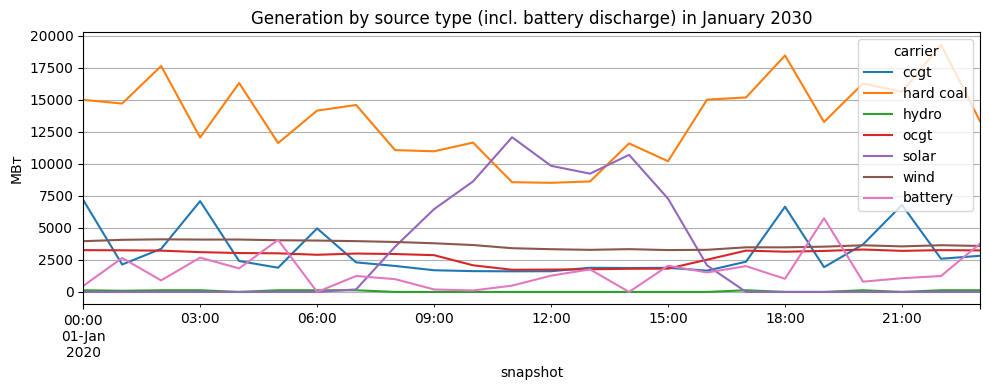

In [266]:
# 1. Генерация по источникам
gen_p = network.generators_t.p.groupby(network.generators.carrier, axis=1).sum()

# 2. Добавляем разряд батарей (только положительная часть)
if hasattr(network, "stores_t") and not network.stores.empty:
    battery_discharge = network.stores_t.p.clip(lower=0).sum(axis=1)  # сумма по всем узлам
    gen_p["battery"] = battery_discharge

# 3. Визуализация
gen_p.plot(title="Generation by source type (incl. battery discharge) in January 2030", figsize=(10, 4))
plt.ylabel("МВт")
plt.grid(True)
plt.tight_layout()
plt.show()

carrier
hard coal    51.829140
wind         14.181541
ccgt         11.866256
solar        11.213410
ocgt         10.679519
hydro         0.230134
dtype: float64


/var/folders/1s/c9vjd4d56sx8xysxk042mq1r0000gn/T/ipykernel_1368/1287529733.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  carrier_generation = generation.groupby(network.generators.carrier, axis=1).sum()


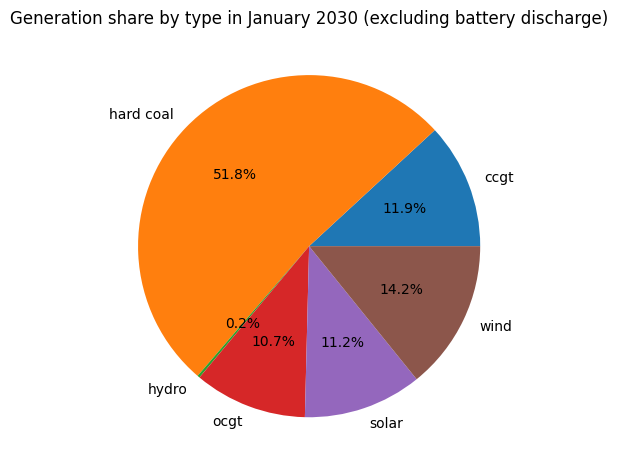

In [267]:
# 1. Генерация по источникам
generation = network.generators_t.p
carrier_generation = generation.groupby(network.generators.carrier, axis=1).sum()

# 2. Без включения батарей в генерацию (иначе будет двойной учёт!)
# battery_discharge = network.stores_t.p.clip(lower=0).sum(axis=1)
# carrier_generation.loc[:, "battery"] = battery_discharge.sum()

# 3. Рассчитываем доли
total_generation = carrier_generation.sum().sum()
carrier_share = carrier_generation.sum() / total_generation * 100

# 4. Вывод
print(carrier_share.sort_values(ascending=False))
carrier_share.plot(kind='pie', autopct='%1.1f%%', ylabel='', title='Generation share by type in January 2030 (excluding battery discharge)')
plt.tight_layout()
plt.show()


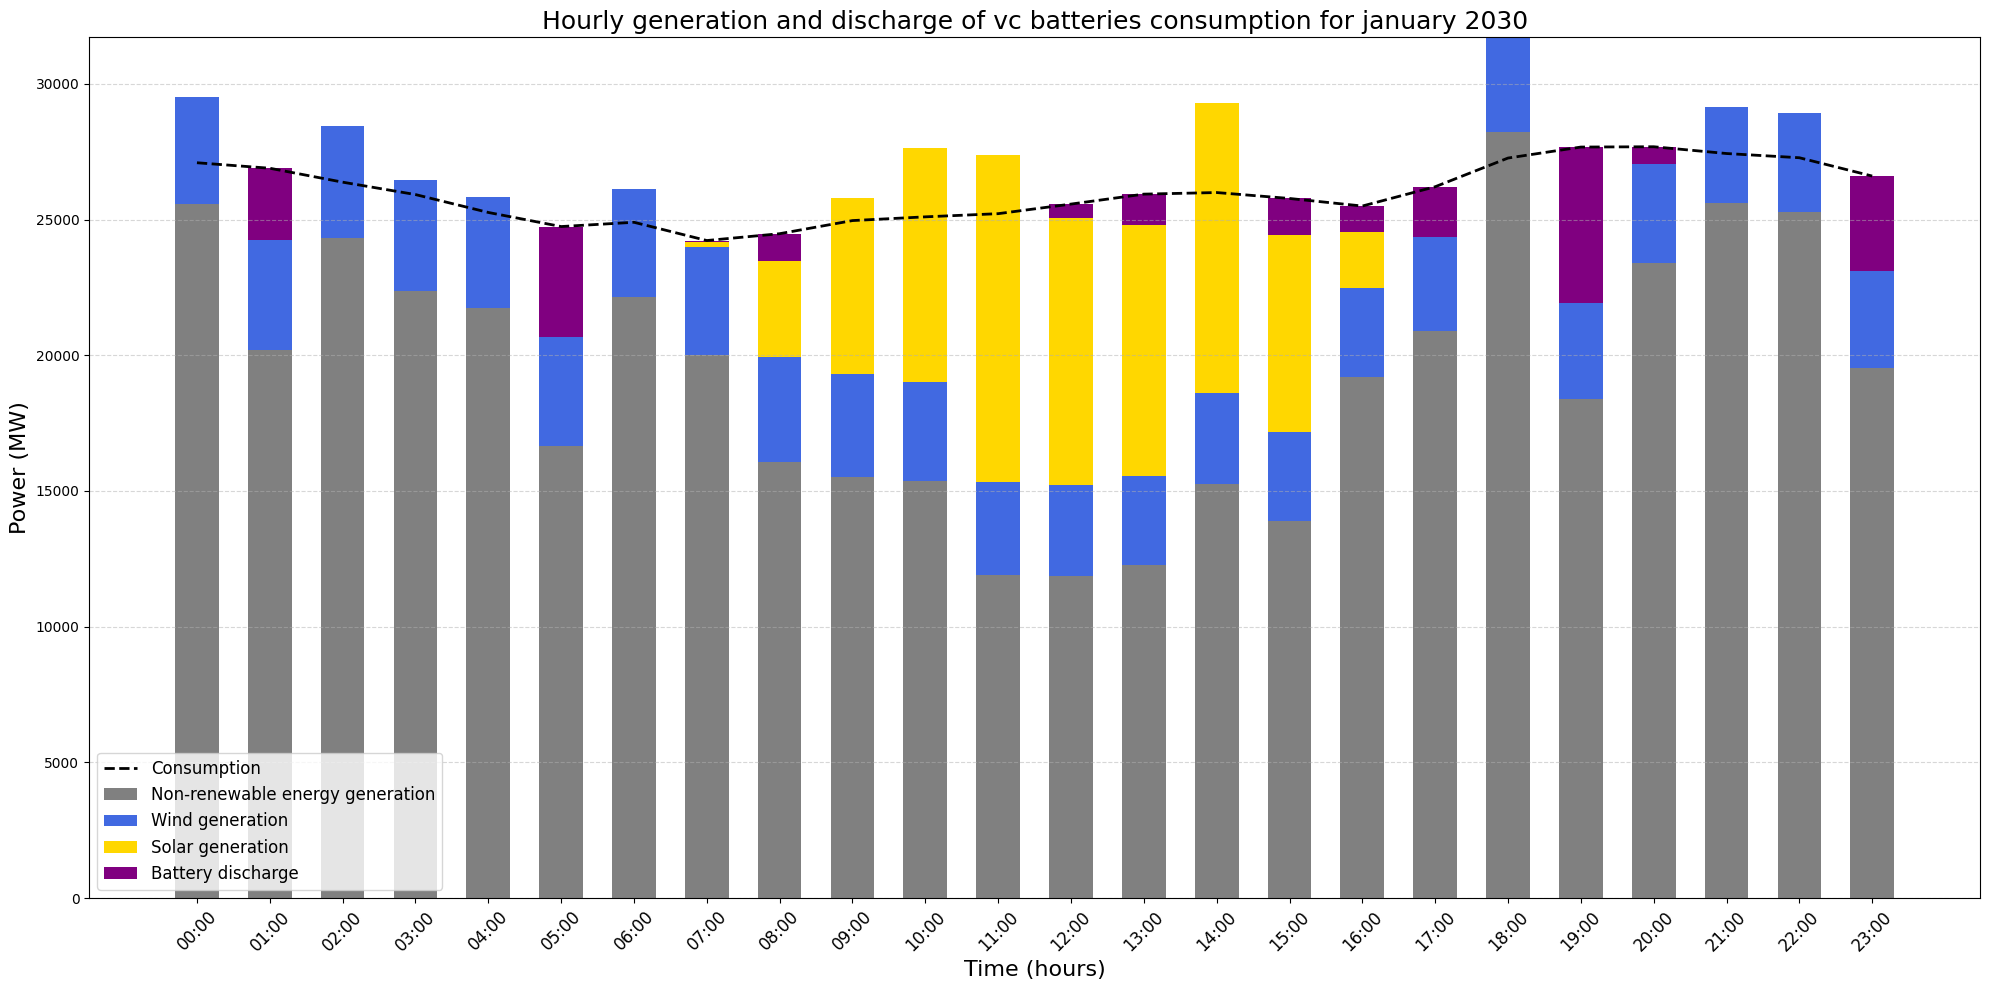

In [268]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Получаем данные
hours = network.snapshots
demand = network.loads_t.p_set.sum(axis=1)

# генерация по группам
gen = network.generators_t.p
solar_generation = gen.loc[:, network.generators.carrier == "solar"].sum(axis=1)
wind_generation = gen.loc[:, network.generators.carrier == "wind"].sum(axis=1)
non_renewable_generation = gen.loc[:, ~network.generators.carrier.isin(["solar", "wind"])].sum(axis=1)

# батареи (если есть)
if hasattr(network, "stores_t") and not network.stores.empty:
    battery_power = network.stores_t.p.sum(axis=1)
    battery_discharge = battery_power.clip(lower=0)
else:
    battery_discharge = pd.Series(0, index=hours)

# 2. Берём первые 24 часа для примера
sample_hours = hours[:24]
x = np.arange(len(sample_hours))
bar_width = 0.6

# 3. Получаем значения
non_renew_sample = non_renewable_generation.loc[sample_hours]
solar_sample = solar_generation.loc[sample_hours]
wind_sample = wind_generation.loc[sample_hours]
battery_discharge_sample = battery_discharge.loc[sample_hours]
demand_sample = demand.loc[sample_hours]

# 4. Рисуем график
plt.figure(figsize=(20, 10))

p1 = plt.bar(x, non_renew_sample, width=bar_width, label='Non-renewable energy generation', color='gray')
p2 = plt.bar(x, wind_sample, width=bar_width, bottom=non_renew_sample, label='Wind generation', color='royalblue')
p3 = plt.bar(x, solar_sample, width=bar_width, bottom=non_renew_sample + wind_sample, label='Solar generation', color='gold')
p4 = plt.bar(x, battery_discharge_sample, width=bar_width,
             bottom=non_renew_sample + wind_sample + solar_sample,
             label='Battery discharge', color='purple')

plt.plot(x, demand_sample.values, color='black', linestyle='--', linewidth=2, label='Consumption')

# Оформление
plt.xticks(x, [t.strftime('%H:%M') for t in sample_hours], rotation=45, fontsize=12)
plt.xlabel("Time (hours)", fontsize=16)
plt.ylabel("Power (MW)", fontsize=16)
plt.title("Hourly generation and discharge of vc batteries consumption for january 2030", fontsize=18)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [269]:
# # --- СОХРАНЕНИЕ РЕЗУЛЬТАТОВ СЦЕНАРИЯ БЕЗ ESS ---

# # 1. Сохраняем генерацию по каждому типу
# gen_p = network.generators_t.p.groupby(network.generators.carrier, axis=1).sum()
# gen_p.to_csv("scenario_no_ess_generation_january.csv")

# # 2. Сохраняем загрузку линий: максимальная загрузка как % от номинальной мощности
# line_loading = abs(network.lines_t.p0 / network.lines.s_nom)
# line_loading_max = line_loading.max()
# line_loading_max.to_csv("scenario_no_ess_line_loading_january.csv")

# # 3. Сохраняем curtailment (недоиспользованную мощность ВИЭ)
# curtailment = pd.Series(0.0, index=network.snapshots)

# for gen_name, row in network.generators.iterrows():
#     if row["carrier"] in ["solar", "wind"]:
#         potential = network.generators_t.p_max_pu[gen_name] * row["p_nom"]
#         actual = network.generators_t.p[gen_name]
#         curtailed = potential - actual
#         curtailment += curtailed

# curtailment.to_csv("scenario_no_ess_curtailment_january.csv")

# --- СОХРАНЕНИЕ РЕЗУЛЬТАТОВ СЦЕНАРИЯ С ESS ---

# 1. Сохраняем генерацию по каждому типу (включая разряд батареи)
gen_p_ess = network.generators_t.p.groupby(network.generators.carrier, axis=1).sum()

# Добавим столбец "battery" если есть
if hasattr(network, "stores_t") and not network.stores.empty:
    battery_discharge = network.stores_t.p.clip(lower=0).sum(axis=1)
    gen_p_ess["battery"] = battery_discharge

gen_p_ess.to_csv("scenario_with_ess_generation_january.csv")

# 2. Сохраняем загрузку линий
line_loading_ess = abs(network.lines_t.p0 / network.lines.s_nom)
line_loading_max_ess = line_loading_ess.max()
line_loading_max_ess.to_csv("scenario_with_ess_line_loading_january.csv")

# 3. Сохраняем curtailment
curtailment_ess = pd.Series(0.0, index=network.snapshots)

for gen_name, row in network.generators.iterrows():
    if row["carrier"] in ["solar", "wind"]:
        potential = network.generators_t.p_max_pu[gen_name] * row["p_nom"]
        actual = network.generators_t.p[gen_name]
        curtailed = potential - actual
        curtailment_ess += curtailed

curtailment_ess.to_csv("scenario_with_ess_curtailment_january.csv")



/var/folders/1s/c9vjd4d56sx8xysxk042mq1r0000gn/T/ipykernel_1368/1173517680.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  gen_p_ess = network.generators_t.p.groupby(network.generators.carrier, axis=1).sum()


In [263]:
# ---  Добавление ESS в ключевые узлы (20–30% от ВИЭ) ---
ess_share = 0.25  # Можно варьировать: 0.2–0.3
ess_efficiency = 0.9  # КПД ESS

# Узлы, в которые добавляем ESS
ess_nodes = ['AKM1', 'ZHAM', 'TURK', 'PAV', 'ALM']

for bus in ess_nodes:
    # Общая установленная мощность ВИЭ (солнечные + ветровые генераторы) на этом узле
    vres_capacity = network.generators.loc[
        (network.generators['bus'] == bus) &
        (network.generators['carrier'].isin(['solar', 'wind'])),
        'p_nom'
    ].sum()

    if vres_capacity == 0:
        print(f"⚠️ Пропущен узел {bus}, нет ВИЭ генерации")
        continue

    ess_power = vres_capacity * ess_share          # Мощность [MW]
    ess_energy = ess_power * 4                     # Ёмкость [MWh] — допустим, 4 часа работы

    # Добавляем Store (накопитель энергии)
    network.add("Store",
                name=f"ESS_{bus}",
                bus=bus,
                e_cyclic=True,
                e_nom=ess_energy,
                e_nom_extendable=False,
                carrier='battery',
                marginal_cost=0.0)

    # Добавляем Link (заряд/разряд)
    network.add("Link",
                name=f"ESS_Link_{bus}",
                bus0=bus,           # от сети
                bus1=bus,           # к батарее
                p_nom=ess_power,
                p_nom_extendable=False,
                efficiency=ess_efficiency,
                carrier='battery',
                capital_cost=0)     # можно указать капзатраты, если нужно


In [264]:
network.optimize()

Index(['ESS_AKM1', 'ESS_ZHAM', 'ESS_TURK', 'ESS_PAV', 'ESS_ALM'], dtype='object', name='Store')
Index(['ESS_Link_AKM1', 'ESS_Link_ZHAM', 'ESS_Link_TURK', 'ESS_Link_PAV',
       'ESS_Link_ALM'],
      dtype='object', name='Link')
Index(['ESS_AKM1', 'ESS_ZHAM', 'ESS_TURK', 'ESS_PAV', 'ESS_ALM'], dtype='object', name='Store')
Index(['ESS_Link_AKM1', 'ESS_Link_ZHAM', 'ESS_Link_TURK', 'ESS_Link_PAV',
       'ESS_Link_ALM'],
      dtype='object', name='Link')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 4848 primals, 10056 duals
Objective: 3.04e+07
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Line-fix-s-lower, Line-fix-s-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Kirchhoff-Voltage-Law, Store-ene

Running HiGHS 1.9.0 (git hash: fa40bdf): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-01, 6e+02]
  Cost   [4e+01, 5e+01]
  Bound  [0e+00, 0e+00]
  RHS    [8e-02, 1e+05]
Presolving model
554 rows, 3298 cols, 4174 nonzeros  0s
365 rows, 2696 cols, 3384 nonzeros  0s
313 rows, 932 cols, 1400 nonzeros  0s
265 rows, 808 cols, 1256 nonzeros  0s
Presolve : Reductions: rows 265(-9791); columns 808(-4040); elements 1256(-14056)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
        377     3.0431363185e+07 Pr: 0(0); Du: 0(2.66454e-15) 0s
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-mlgsd19e
Model status        : Optimal
Simplex   iterations: 377
Objective value     :  3.0431363185e+07
Relative P-D gap    :  2.4483229856e-16
HiGHS run time      :          0.01
Writing the solution to /private

('ok', 'optimal')